# Метод k ближайших соседей (KNN)

Алгоритм KNN устроен следующим образом:

- На стадии обучения KNN берёт обучающую выборку и просто запоминает её
- На стадии тестирования KNN ищет k ближайших векторов к вектору запросу и выбирает в качестве предсказания самый частый среди них класс (или делает более "умную" агрегацию лейблов)

В данном задании вы реализуете эти шаги и примените свой алгоритм для решения задачи классификации рукописных цифр. Также вы реализуете метод предсказания тремя различными способами, чтобы убедиться насколько полезна может быть библиотека `numpy`.
Вы будете работать с датасетом рукописных цифр, изображения которых имеют размер 8x8. Двумерные изображения будут вытянуты в вектора размера 64.

In [2]:
from sklearn import datasets
dataset = datasets.load_digits()
print(dataset.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 1797
:Number of Attributes: 64
:Attribute Information: 8x8 image of integer pixels in the range 0..16.
:Missing Attribute Values: None
:Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
:Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an in

In [3]:
# Первые 100 изображений будут использованы для тестирования
# Этот датасет уже заранее перемешан, потому шафлить его дополнительно не нужно
# В целом всегда помните и задумывайтесь, нужно ли вам перемешивать данные перед сплитом
test_border = 100
X_train, y_train = dataset.data[test_border:], dataset.target[test_border:]
X_test, y_test = dataset.data[:test_border], dataset.target[:test_border]

print('Размер design matrix: ', X_train.shape)
print('Размер вектора тренировочных лейблов: ', y_train.shape)
print('Размер матрицы тестовых данных: ', X_test.shape)
print('Размер вектора тестовых лейблов: ', y_test.shape)
num_test = X_test.shape[0]

Размер design matrix:  (1697, 64)
Размер вектора тренировочных лейблов:  (1697,)
Размер матрицы тестовых данных:  (100, 64)
Размер вектора тестовых лейблов:  (100,)


In [5]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Немного техниеского кода для отрисовки графиков
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

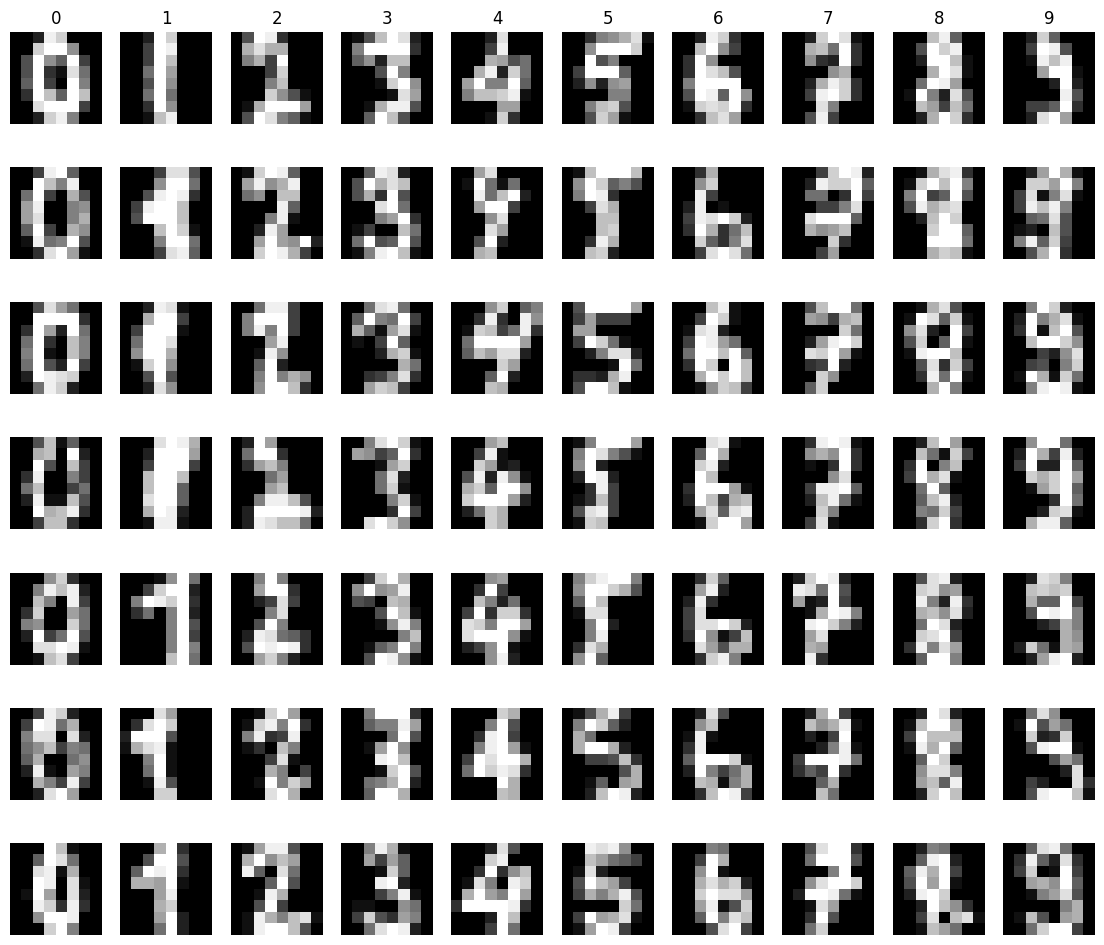

In [6]:
# Посмотрим на некоторые примеры из датасета
# Нарисуем несколько примеров из каждого класса из обучающих данных
classes = list(np.arange(10))
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape((8, 8)).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [46]:
class KNearestNeighbor:
    """Метод k ближайших соседей с евклидовым расстоянием """
    def fit(self, X, y):
        """
        Метод обучения классификатора
        Для KNN обучение заключается лишь в запоминании обучающей выборки

        Вход:
        - X: numpy массив обучающих данных размера (num_train, D),
          состоящий из num_train векторов размерности D каждый
        - y: numpy массив размера (num_train,), состоящий из лейблов, причём
             y[i] лейбл соответствует объекту X[i]
        """
        self.X_train = X
        self.y_train = y

    def predict(self, X, k=1, num_loops=0):
        """
        Метод предсказания
        
        Вход:
        - X: numpy массив тестовых данных размера (num_test, D),
          состоящий из num_test векторов размерности D каждый
        - k: количество ближайших соседей, участвующих в голосовании за предсказываемый лейбл 
        - num_loops: количество циклов, используемое для подсчета расстояний между векторами.
          Определяет какая имплементация будет использована

        Выход:
        - y: numpy массиив размера (num_test,), состоящий из предсказанных лейблов для данных X.
          Причём y[i] лейбл соответствует объекту X[i]
        """
        if num_loops == 0:
            dists = self.compute_distances_no_loops(X)
        elif num_loops == 1:
            dists = self.compute_distances_one_loop(X)
        elif num_loops == 2:
            dists = self.compute_distances_two_loops(X)
        else:
            raise ValueError('Неподходящее значение %d для аргумента num_loops' % num_loops)

        return self.predict_labels(dists, k=k)

    def compute_distances_two_loops(self, X):
        """
        Вычисляет расстояния между всеми тестовыми объектами в X и обучающими
        объектами в self.X_train при помощи двойного цикла по X и по self.X_train

        Вход:
        - X: numpy массив размера (num_test, D), состоящий из тестовых данных

        Выход:
        - dists: numpy массив размера (num_test, num_train), где dists[i, j] - это 
          евклидово расстояние между i-ым тестовым и j-ым обучающим объектами
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in range(num_test):
            for j in range(num_train):
                ##################################################################
                # TODO:                                                          #
                # Вычислите l2 расстояние между i-ым тестовым и j-ым обучающим   #
                # объектами и запишите результат в dists[i, j]. Вы не должны     #
                # использовать ни цикл по размерности векторов ни np.linalg.norm #
                ##################################################################
              dists[i, j] = ((X[i] - self.X_train[j])**2).sum()**(1/2)

        return dists

    def compute_distances_one_loop(self, X):
        """
        Вычисляет расстояния между всеми тестовыми объектами в X и обучающими
        объектами в self.X_train при помощи одного цилка по тестовым данным

        Вход / Выход: Аналогичные compute_distances_two_loops
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in range(num_test):
            ################################################################
            # TODO:                                                        #
            # Вычислите l2 расстояние между i-ым тестовым объектом и всеми #
            # обучающими объектами и запишите результат в dists[i, :]      #
            # Не используйте np.linalg.norm                                #
            ################################################################
            dists[i, :] = ((X[i] - self.X_train)**2).sum(axis=1)**(1/2)

        return dists

    def compute_distances_no_loops(self, X):
        """
        Вычисляет расстояния между всеми тестовыми объектами в X и обучающими
        объектами в self.X_train без использовния циклов

        Вход / Выход: Аналогичные compute_distances_two_loops
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        ########################################################################
        # TODO:                                                                #
        # Вычислите l2 расстояние между всеми тестовыми и обучающими объектами #
        # без помощи циклов и запишите результат в dists                       #
        #                                                                      #
        # Вы должны реализовать этот метод, используя только базовые операции  #
        # над numpy массивами. Вы не должны использовать ни готовые функции из #
        # scipy, ни np.linalg.norm                                             #
        #                                                                      #
        # Подсказка: Вам может помочь broadcasting                             #
        ########################################################################
        x2 = np.sum(X**2, axis=1).reshape((num_test, 1))
        y2 = np.sum(self.X_train**2, axis=1).reshape((1, num_train))
        xy = X.dot(self.X_train.T)
        dists = np.sqrt(x2 + y2 - 2*xy)
        return dists

    def predict_labels(self, dists, k=1):
        """
        По матрице расстояний между тестовыми и обучающими объектами предсказывает
        лейбл для каждого тестового объекта

        Вход:
        - dists: numpy массив размера (num_test, num_train), где dists[i, j] - это 
          евклидово расстояние между i-ым тестовым и j-ым обучающим объектами
        Выход:
        - y: numpy массив размера (num_test,), состоящий из предсказаний на тестовых
          данных, где y[i] - предсказанный лейбл для i-го тестового объекта
        """
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            #####################################################################
            # TODO:                                                             #
            # Используйте матрицу расстояний dists для нахождения k ближайших   #
            # соседей для i-го тестового объекта и используёте self.y_train для #
            # нахождения лейблов этих объектов.                                 #
            # Подсказка: Вам может понадобиться np.argsort.                     #
            #####################################################################

            ########################################################################
            # TODO:                                                                #
            # После того как вы нашли лейблы k ближайших соседей найдите лейбл,    #
            # встречающийся среди них чаще всего. Запишите этот лейбл в y_pred[i]. #
            # При одинаковых частотах лейблов выбирайте наименьший.                #
            ########################################################################
            labels = np.argsort(dists[i])[:k]
            values = np.take(self.y_train, labels)
            y_pred[i] = np.bincount(values).argmax()
        return y_pred

In [47]:
# Создаём инстанс классификатора и "обучаем" его
classifier = KNearestNeighbor()
classifier.fit(X_train, y_train)
y_train

array([4, 0, 5, ..., 8, 9, 8])

In [22]:
X_train.shape

(1697, 64)

Мы хотим классифицировать тестовые объекты с помощью KNN. Обратите внимание, что мы можем разделить этот процесс на 2 шага:

1. Сначала вычисляем расстояния между всеми тестовыми и обучающими объектами
2. Имея расстояния, для каждого тестового примера находим k ближайших обучающих объектов и выдаем наиболее частый среди них класс

# 1. `compute_distances_two_loops`
Прежде чем запускать код ниже, реализуйте метод `compute_distances_two_loops` у класса `KNearestNeighbor`. Перезапустите клетки с определением этого класса и обучением алгоритма, чтобы изменения, которые вы внесли в методы, вступили в силу.

In [11]:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(100, 1697)


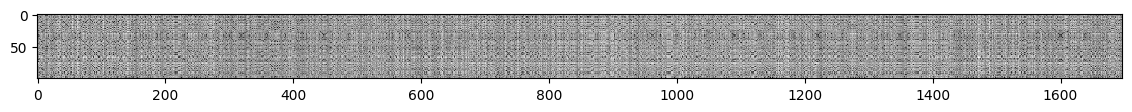

In [12]:
# Мы можем визуализировать матрицу расстояний:
plt.imshow(dists, interpolation='none')
plt.show()

## Вопрос 1 

Обратите внимание на то, что матрица расстояний имеет некоторые структурированные паттерны - некоторые строки/столбцы видны ярче других
(чем белее ячейка матрицы, тем больше значение в ячейке)

- Что является причиной ярких строк?
- А столбцов?

$\color{blue}{\textit{Ваш ответ:}}$
Строки это тестовые объекты. Значит если строка яркая, значит данный тестовый объект не похож ни на один из объектов в тренировочном наборе
Столбцы это элементы тренировочного набора. Яркие столбыц означают, что какой-то из элементов тренировочного набора не похож ни на один элемент тестовой выборки.


# 2. `predict_labels`

Прежде чем запускать код ниже, реализуйте метод `predict_labels` у класса `KNearestNeighbor`. Перезапустите клетки с определением этого класса и обучением алгоритма, чтобы изменения, которые вы внесли в методы, вступили в силу.

In [13]:
y_test_pred = classifier.predict_labels(dists, k=1)

# Посчитаем количество правильных предсказаний
num_correct = np.sum(y_test_pred == y_test)
accuracy = num_correct / num_test
print('Доля правильных ответов: %d / %d => точность: %f' % (num_correct, num_test, accuracy))

Доля правильных ответов: 95 / 100 => точность: 0.950000


Вы должны получить около `95%` точности. Теперь давайте попробуем увеличить `k`, возьмём например `k = 5`:

In [14]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Доля правильных ответов: %d / %d => точность: %f' % (num_correct, num_test, accuracy))

Доля правильных ответов: 93 / 100 => точность: 0.930000


Точность должна снизиться до примерно `93%`

## Вопрос 2

Мы также можем использовать другую функцию расстояния, например [L1 метрику](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2).

Для значений пикселей $p_{ij}^{(k)}$ на позиции $(i,j)$ изображения $I_k$, 
среднее значений $\mu$ среди всех пикселей по всем изображениям: $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
И попиксельное среднее $\mu_{ij}$ по всем изображениям: 
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
Стандартное отклонение (корень из дисперсии) $\sigma$ и попиксельное стандартное отклонение $\sigma_{ij}$ определяются аналогично.

Какие из следующих шагов предобработки данных не повлияют на работу KNN-а, использующего L1 метрику?
1. Вычитание среднего $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Вычитание попиксельного среднего $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Вычитание среднего $\mu$ и деление на стандартное отклонение $\sigma$.
4. Вычитание попиксельного среднего $\mu_{ij}$ и деление на попиксельное стандартное отклонение $\sigma_{ij}$.
5. Поворот координатных осей данных

$\color{blue}{\textit{Ваш ответ:}}$ Поворот координатных осей данных


$\color{blue}{\textit{Ваше объяснение:}}$ Если я правильно понял, то разворот координатных осей будет не только во всей выборке, значит не должен повлиять на общий результат.

# 3. `compute_distances_one_loop`

Теперь давайте ускорим вычисление матрицы расстояний частичо векторизуя код и используя только 1 цикл. Прежде чем запускать код ниже, реализуйте метод `compute_distances_one_loop` у класса `KNearestNeighbor`. Перезапустите клетки с определением этого класса и обучением алгоритма, чтобы изменения, которые вы внесли в методы, вступили в силу.

In [27]:
dists_one = classifier.compute_distances_one_loop(X_test)

# Чтобы удостовериться, что векторизованная имплементация вычисления матрицы расстояний верна, мы
# протестируем насколько она согласуется с наивной имплементацией. Есть множество способов сравнить
# 2 матрицы, состоящие из вещественных чисел и понять идентичны ли они. Один из простейших способов -
# посмотреть на норму Фробениуса разницы матриц. Её подсчёт равносилен тому, что мы вытянем матрицы
# в вектора и посчитаем евклидову норму разности между ними
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Норма разности матриц: %f' % (difference, ))
if difference < 0.001:
    print('Отлично! Матрицы совпадают')
else:
    print('Упс! Матрицы различаются')

Норма разности матриц: 0.000000
Отлично! Матрицы совпадают


# 4. `compute_distances_no_loops`

Теперь давайте ускорим вычисление матрицы расстояний полностью векторизовав код. Прежде чем запускать код ниже, реализуйте метод `compute_distances_no_loops` у класса `KNearestNeighbor`. Перезапустите клетки с определением этого класса и обучением алгоритма, чтобы изменения, которые вы внесли в методы, вступили в силу.

In [48]:
dists_two = classifier.compute_distances_no_loops(X_test)

difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Норма разности матриц: %f' % (difference, ))
if difference < 0.001:
    print('Отлично! Матрицы совпадают')
else:
    print('Упс! Матрицы различаются')

Норма разности матриц: 0.000000
Отлично! Матрицы совпадают


# Сравнение с `sklearn`
В данной секции мы сравним нашу имплементацию с имплементацией из `sklearn`. Предсказания должны совпадать.

In [49]:
from sklearn import neighbors

In [50]:
implemented_knn = KNearestNeighbor()
implemented_knn.fit(X_train, y_train)

In [51]:
n_neighbors = 1
external_knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
external_knn.fit(X_train, y_train)
print('sklearn KNN (k=1) достигает: {} точности на тесте'.format(
    external_knn.score(X_test, y_test)
))
y_predicted = implemented_knn.predict(X_test, k=n_neighbors).astype(int)
accuracy_score = sum((y_predicted==y_test).astype(float)) / num_test
print('Наш KNN (k=1) достигает: {} точности на тесте'.format(accuracy_score))
assert np.array_equal(
    external_knn.predict(X_test),
    y_predicted
), 'Предсказания KNN из sklearn и нашего алгоритма не совпадают!'
print('\n Предсказания KNN из sklearn и нашего алгоритма совпадают!')
print('_'*76)


n_neighbors = 5
external_knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
external_knn.fit(X_train, y_train)
print('sklearn KNN (k=5) достигает: {} точности на тесте'.format(
    external_knn.score(X_test, y_test)
))
y_predicted = implemented_knn.predict(X_test, k=n_neighbors).astype(int)
accuracy_score = sum((y_predicted==y_test).astype(float)) / num_test
print('Наш KNN (k=5) достигает: {} точности на тесте'.format(accuracy_score))
assert np.array_equal(
    external_knn.predict(X_test),
    y_predicted
), 'Предсказания KNN из sklearn и нашего алгоритма не совпадают!'
print('\n Предсказания KNN из sklearn и нашего алгоритма совпадают!')
print('_'*76)

sklearn KNN (k=1) достигает: 0.95 точности на тесте
Наш KNN (k=1) достигает: 0.95 точности на тесте

 Предсказания KNN из sklearn и нашего алгоритма совпадают!
____________________________________________________________________________
sklearn KNN (k=5) достигает: 0.93 точности на тесте
Наш KNN (k=5) достигает: 0.93 точности на тесте

 Предсказания KNN из sklearn и нашего алгоритма совпадают!
____________________________________________________________________________


# Измерение производительности
В конце давайте сравним по производительности наши имплементации

Для того, чтобы отличия были лучше видны, мы искусственно увеличим количество обучающих и тестовых данных, повторив их несколько раз

In [52]:
X_train_big = np.vstack([X_train]*5)
X_test_big = np.vstack([X_test]*5)
y_train_big = np.hstack([y_train]*5)
y_test_big = np.hstack([y_test]*5)

In [53]:
classifier_big = KNearestNeighbor()
classifier_big.fit(X_train_big, y_train_big)

def time_function(f, *args):
    """
    Вызывает функцию f с аргументами args и возвращает время, которое потребовалось для выполнения f
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier_big.compute_distances_two_loops, X_test_big)
print('Версия с 2-мя циклами потребовала %f секунд' % two_loop_time)

one_loop_time = time_function(classifier_big.compute_distances_one_loop, X_test_big)
print('Версия с одним циклом потребовала %f секунд' % one_loop_time)

no_loop_time = time_function(classifier_big.compute_distances_no_loops, X_test_big)
print('Версия без циклов потребовала %f секунд' % no_loop_time)

# Версия без циклов должна работать значительно быстрее

Версия с 2-мя циклами потребовала 9.749780 секунд
Версия с одним циклом потребовала 0.954833 секунд
Версия без циклов потребовала 0.070001 секунд


Убрав циклы, вы наверняка получили значительное ускорение

## Вопрос 3

Какие утверждение о KNN верны при решении задачи классификации?

1. Для KNN граница решения (гиперповерхность разделяющая различные классы) линейна независимо от k
2. Ошибка на обучающей выборке при k=1 всегда меньше, чем при k=5
3. Ошибка на тестовой выборке при k=1 всегда меньше, чем при k=5
4. Время, требуемое для классификации тестового объекта растёт с размером обучающего датасета

$\color{blue}{\textit{Ваш ответ:}}$ 4


$\color{blue}{\textit{Ваше объяснение:}}$ Необходимо вычислить расстояние до всех элементов тестовой выборки, соотвественно чем их больше, тем больше времени потребуется.
На счет 1-го утверждения не уверен, т.к. не до конца его понимаю.


## Вопрос 4

В данном ноутбуке вы реализовали алгоритм KNN для решения задачи классификации. Как можно было бы адаптировать алгоритм для решения задачи регрессии?

$\color{blue}{\textit{Ваш ответ:}}$ в качестве результата присваивать среднее от k ближайших соседей.